# Analysis and action plan to retain clients of the fitness center "Bodybuilder-datascientist"

<b>Task</b>

The fitness center "Bodybuilder-datascientist" develops a strategy for interacting with clients based on analytical data.

A common problem for fitness clubs and other services is customer churn. How to understand that the client is no longer with you? You can add to the outflow those who asked to close the contract or deleted the account. However, customers do not always leave defiantly: they often stop using the service quietly.

For a fitness center, we can consider that a client has been churned if he has never visited the gym in the last month. Of course, it is possible that he left for Bali and upon arrival will definitely continue to go to fitness. However, the opposite is more often the case. If a client started a new life on Monday, went to the gym for a bit, and then disappeared, most likely he will not return.

To combat churn, Bodybuilder Data Scientist's customer service department has digitized many client profiles. Our task is to analyze and prepare an action plan to retain customers.

Namely:
* learn to predict the probability of outflow (at the level of the next month) for each client;
* form typical client portraits: identify several of the most striking groups and characterize their main properties;
* analyze the main features that most strongly affect the outflow;
* formulate the main conclusions and develop recommendations for improving the quality of work with clients:<br>
  1) identify target customer groups;<br>
  2) propose measures to reduce churn;<br>
  3) determine other features of interaction with customers.

## Dataset download and analysis

In [3]:
pip install shap --user

     |████████████████████████████████| 567 kB 1.9 MB/s            
     |████████████████████████████████| 15.7 MB 46.3 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import shap
import numpy as np
import itertools

In [2]:
#read dataset
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#basic EDA function
def get_full_info(df):
    pd.set_option('display.float_format', '{:,.2f}'.format)
    display(df.head())
    print("-"*80)
    display(df.describe().T)
    print("-"*80)
    display(df.info())
    print("-"*80)
    print("Количество явных дупликатов:", df.duplicated().sum())
    print("-"*80)
    print("Количество явных пропусков:")
    print(df.isna().sum())
    print("-"*80)

In [4]:
get_full_info(df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


--------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000

None

--------------------------------------------------------------------------------
Количество явных дупликатов: 0
--------------------------------------------------------------------------------
Количество явных пропусков:
gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64
--------------------------------------------------------------------------------


The dataset includes the following fields:

Client data for the previous month before checking the outflow fact:
* 'gender' — gender;
* 'Near_Location' - living or working in the area where the fitness center is located;
* 'Partner' - an employee of the club's partner company (cooperation with companies whose employees can receive discounts on a subscription - in this case, the fitness center stores information about the client's employer);
* Promo_friends - the fact of the initial entry as part of the “bring a friend” promotion (used a promo code from a friend when paying for the first subscription);
* 'Phone' — availability of a contact phone number;
* 'Age' — age;
* 'Lifetime' is the time since the first access to the fitness center (in months).

Information based on the log of visits, purchases and information about the current status of the client's subscription:
* 'Contract_period' — duration of the current active subscription (month, 6 months, year);
* 'Month_to_end_contract' — term until the end of the current active subscription (in months);
* 'Group_visits' — the fact of attending group classes;
* 'Avg_class_frequency_total' — the average frequency of visits per week for the entire time since the start of the subscription;
* 'Avg_class_frequency_current_month' — average frequency of visits per week for the previous month;
* 'Avg_additional_charges_total' — total revenue from other services of the fitness center: cafe, sporting goods, cosmetic and massage salon.
* 'Churn' — churn fact in the current month.

### Conclusions

There are 4000 records and 14 columns in our dataset, there are no obvious duplicates and gaps. There are only numerical values in the dataset, there are no categorical ones. At first glance, it seems that the quality and quantity of data will allow us to solve the tasks.

## EDA

In [5]:
#change columns to lower register
columns = []
for column in list(df.columns):
    column = column.lower()
    columns.append(column)

In [6]:
df.columns = columns
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [7]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


In [8]:
df.groupby('churn')['churn'].count()

churn
0    2939
1    1061
Name: churn, dtype: int64

In [9]:
df.groupby('churn')[columns[:-1]].mean() #[columns[:-1]] позволяет нам выбрать все колонки, кроме churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


In [10]:
df_churn_false = df.query('churn == 0')
df_churn_true = df.query('churn == 1')

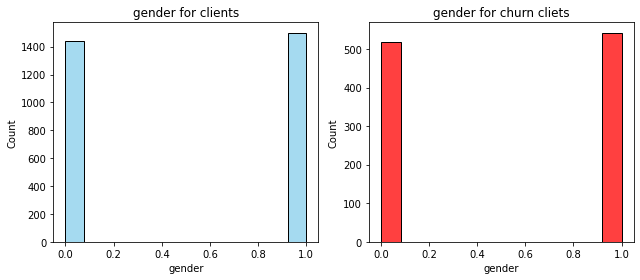

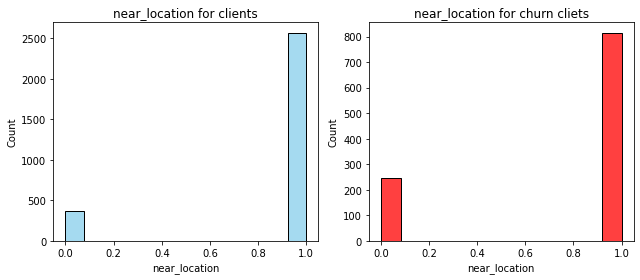

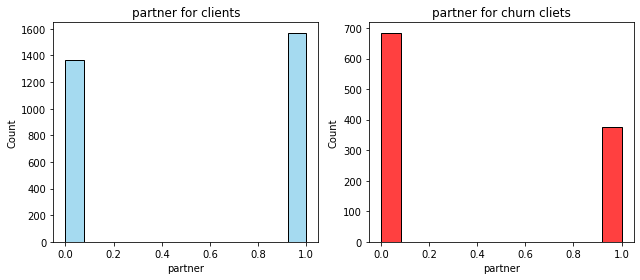

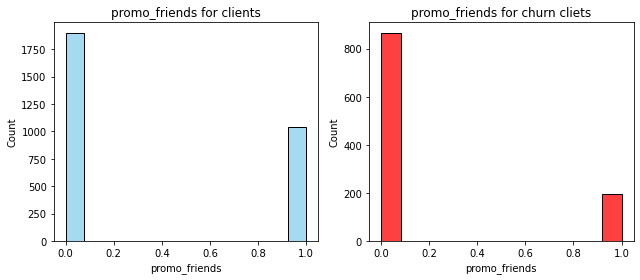

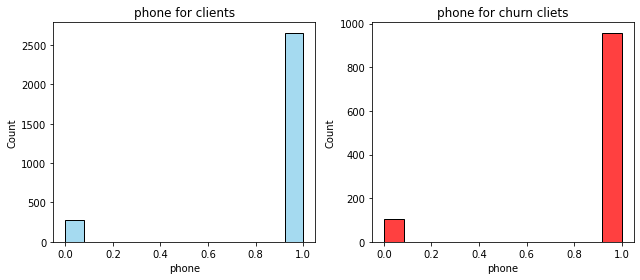

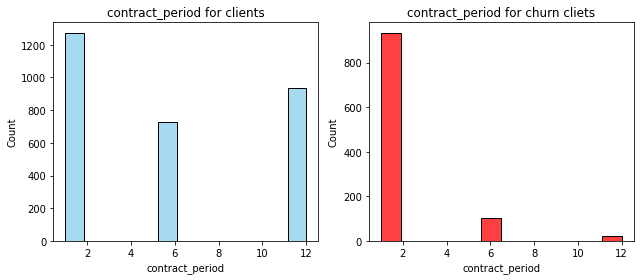

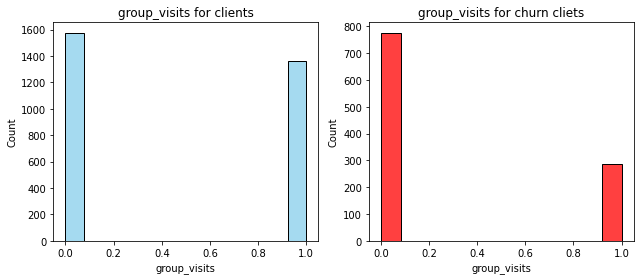

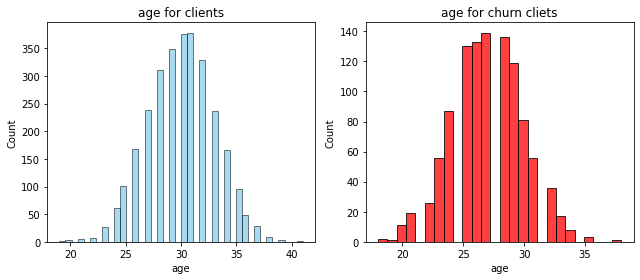

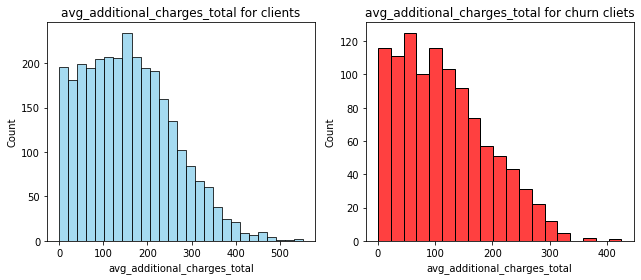

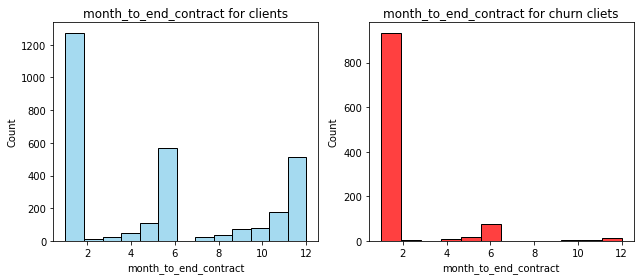

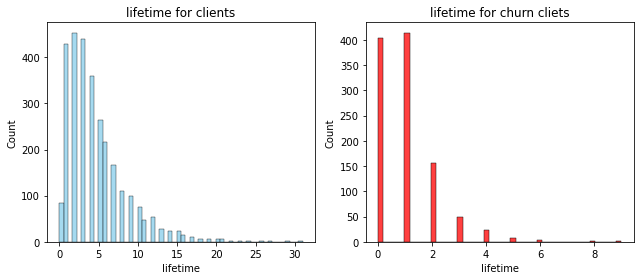

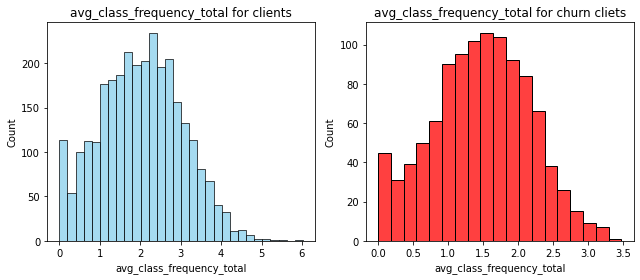

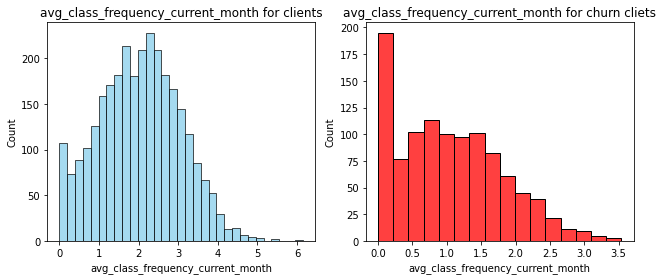

In [11]:
for column in columns[:-1]:
    fig, axs = plt.subplots(1, 2, figsize = (9,4))
    axs[0].set_title('{0} for clients'.format(column))
    sns.histplot(data = df_churn_false[column], ax = axs[0], color="skyblue")
    axs[1].set_title('{0} for churn cliets'.format(column))
    sns.histplot(data = df_churn_true[column], ax = axs[1], color = 'red')
    fig.tight_layout()
    fig.show()

<AxesSubplot:>

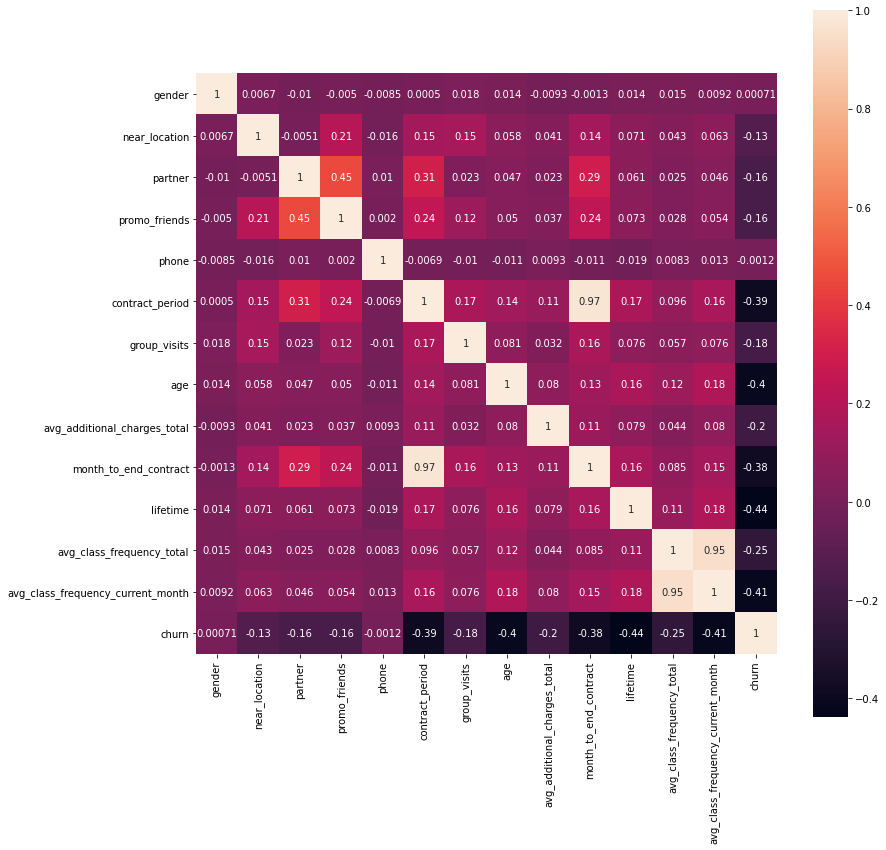

In [12]:
plt.figure(figsize=(13,13))
cm = df.corr()
sns.heatmap(cm, annot=True, square=True)

### Conclusions

A quarter of all visitors for the analyzed period were in the outflow. Based on the EDA results, we can say that these clients were less connected to the fitness center, the average values ​​of indicators in this group are lower than among the remaining clients. In 95% of cases, among the departed clients, lifetime did not exceed 3 months, and on average it was 1 month. Most of the departed made out a contract for one month. It may be worth trying some short questionnaire to collect data on why the fitness center is not on trial with customers.

Among the features, two pairs of strongly correlated values ​​were found (month_to_end_contract : contract_period; avg_class_frequency_total : avg_class_frequency_current_month). Although strongly correlated characteristics can be used for logical regression, it is possible to get rid of multicollinearity and compare with the full dataset to build different ML models.

None of the features showed a strong correlation with the target variable. It can already be said that the lower the subscription period, the time since the request and the average attendance, the higher the probability of a customer churn.

## Churn Prediction Models

### Building models with all features

In [39]:
# divide our data into features (matrix X) and target variable (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# split the model into training and validation sets with proportion 80%:20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
display(X_train.shape)
display(X_test.shape)

(3200, 14)

(800, 14)

In [14]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [15]:
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state = 0),
]

In [16]:
def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    mape = perc_error_abs.sum() / len(y_true)
    return mape

In [17]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_proba)))
    print('')

In [18]:
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
ROC_AUC: 0.97

RandomForestClassifier(random_state=0)
Accuracy: 0.92
Precision: 0.84
Recall: 0.81
ROC_AUC: 0.97



### Building models with features without strong correlation 

In [19]:
X_cut = df.drop(['churn', 'avg_class_frequency_current_month', 'month_to_end_contract'], axis = 1)
y_cut = df['churn']

# divide model for tran and test with proportion 80%:20%
X_train_cut, X_test_cut, y_train_cut, y_test_cut = train_test_split(X_cut, y_cut, test_size=0.2, random_state=0)

In [20]:
X_train_st_cut = scaler.fit_transform(X_train_cut)

X_test_st_cut = scaler.transform(X_test_cut)

In [21]:
for i in models:
    print(i)
    make_prediction(i, X_train_st_cut, y_train_cut, X_test_st_cut, y_test_cut)

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.90
Precision: 0.79
Recall: 0.81
ROC_AUC: 0.95

RandomForestClassifier(random_state=0)
Accuracy: 0.89
Precision: 0.79
Recall: 0.76
ROC_AUC: 0.94



### Weights for models

In [22]:
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(X_train_st, y_train)
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [23]:
weights = (pd.DataFrame({'weight_lr': lr_model.coef_[0], 'weight_rf': rf_model.feature_importances_}, 
             columns=['weight_lr',  'weight_rf'], index = X_train.columns)
           .sort_values(by='weight_rf', ascending=False))
weights

,weight_lr,weight_rf
lifetime,-3.72,0.28
avg_class_frequency_current_month,-4.43,0.18
avg_class_frequency_total,3.29,0.13
age,-1.07,0.12
avg_additional_charges_total,-0.54,0.09
month_to_end_contract,-0.52,0.07
contract_period,-0.70,0.07
group_visits,-0.39,0.02
gender,-0.01,0.01
partner,-0.08,0.01


In [24]:
explainer = shap.LinearExplainer(lr_model, X_train_st, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_st)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


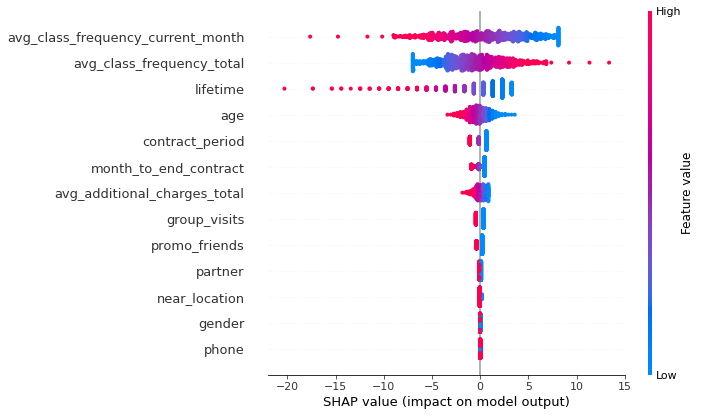

In [25]:
shap.summary_plot(shap_values, X_test_st, feature_names=columns[:-1])

### Сonclusions

We built two models of binary classification of customers (a logistic regression model and a random forest model), where the target feature is the fact that a customer churns in the next month:

The logistic regression model was slightly better on the Precision and Recall metrics (0.85, 0.83 for regression and 0.84, 0.81 for forest). Accuracy is the same for both models and is equal to 0.92
The most significant features in both models are the average number of visits over the last month and lifetime.

The same models without strongly correlated characteristics showed a slightly worse result in all respects, so we reject them.

## Client clustering

 ### Distance matrix by function

In [26]:
linked = linkage(X_train_st, method = 'ward')

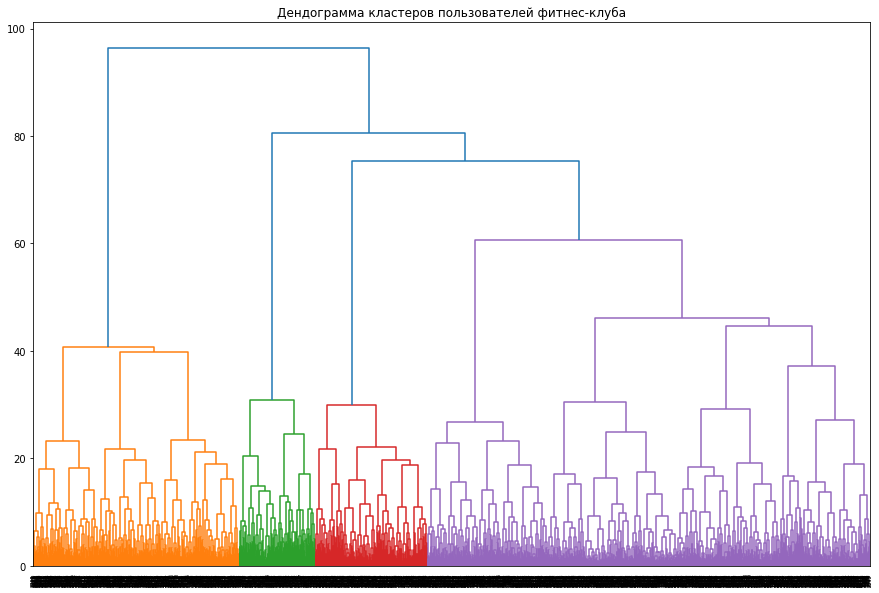

In [27]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма кластеров пользователей фитнес-клуба')
plt.show() 

In [28]:
X_st = StandardScaler().fit_transform(X)

### Shoulder Method for Calculating the Optimal Number of Clusters

In [29]:
wcss = [] #empty list for Within-Cluster Sum of Square for each number of cluster
for i in range(1, 31): #for loop with standard Kmeans() function
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
    kmeans.fit(X_st)
    wcss.append(kmeans.inertia_) #append WCSS to the list for each number of cluster

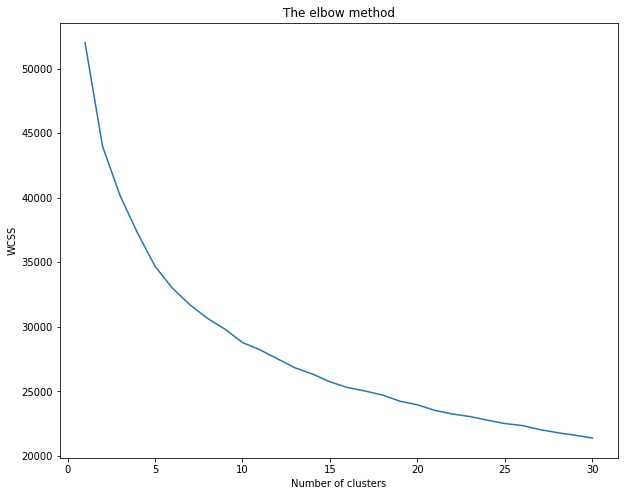

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 31), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The leverage method did not help to identify the best number of clusters, so we will focus on 5 clusters

### Clustering model based on the K-Means algorithm for 5 clusters

In [40]:
# set the number of clusters to 5 and fix the random_state value for reproducible results
km = KMeans(n_clusters=5, random_state=0) 

In [32]:
labels = km.fit_predict(X_st)
df['cluster'] = labels

In [33]:
df.groupby('cluster')[columns].mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


In [34]:
df.groupby('cluster')['cluster'].count()

cluster
0    1010
1     385
2     505
3    1262
4     838
Name: cluster, dtype: int64

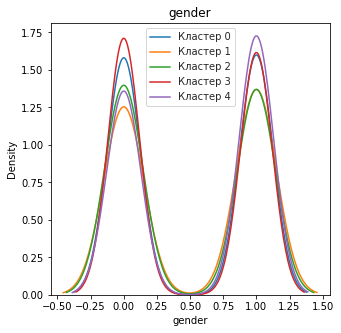

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


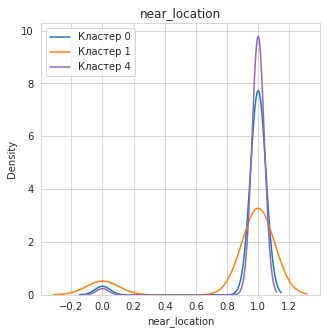

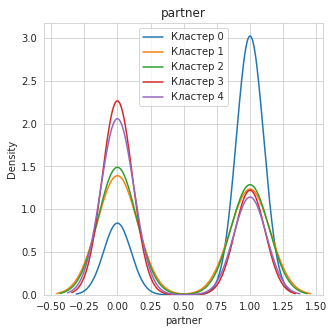

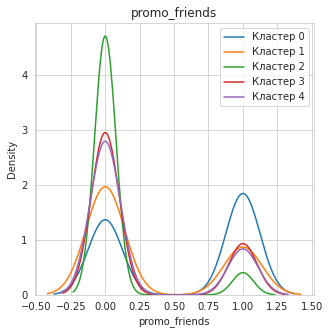

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


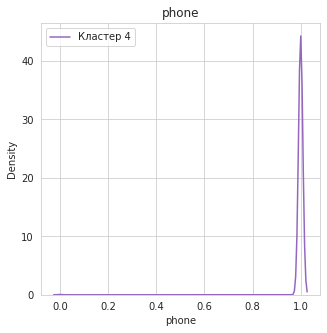

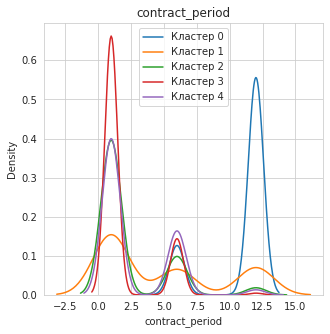

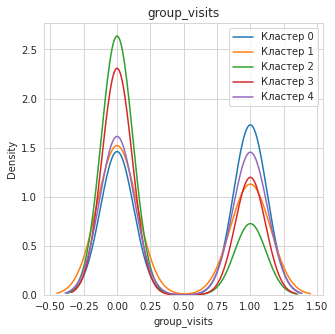

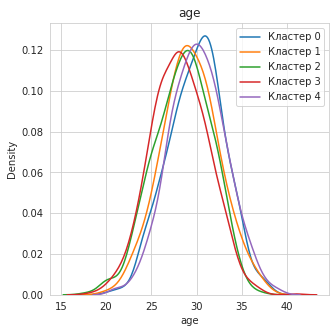

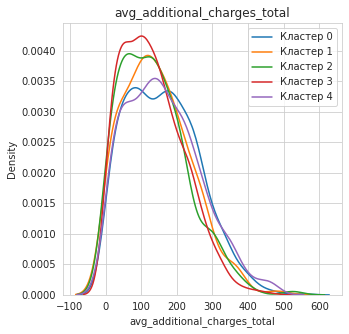

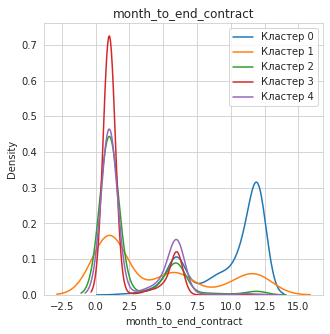

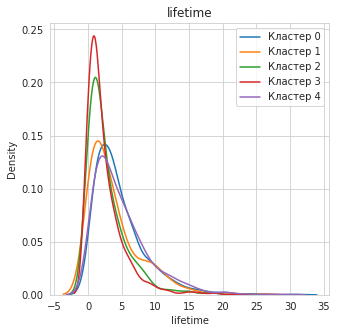

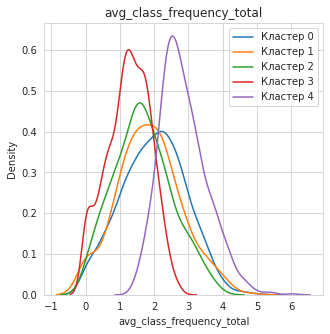

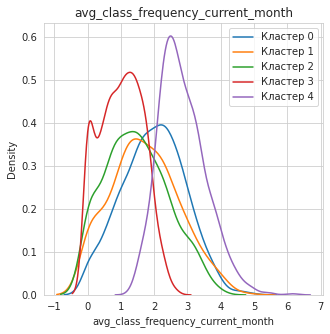

In [35]:
for column in columns[:-1]:
    plt.figure(figsize=(5, 5))
    plt.title(column)   
    sns.kdeplot(df.query('cluster == 0')[column], label = 'Кластер 0')
    sns.kdeplot(df.query('cluster == 1')[column], label = 'Кластер 1')
    sns.kdeplot(df.query('cluster == 2')[column], label = 'Кластер 2')
    sns.kdeplot(df.query('cluster == 3')[column], label = 'Кластер 3')
    sns.kdeplot(df.query('cluster == 4')[column], label = 'Кластер 4')
    
    sns.set_style('whitegrid')
    plt.legend()
    plt.show()

In [43]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
       data = df, x = x_name, y = y_name, hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()


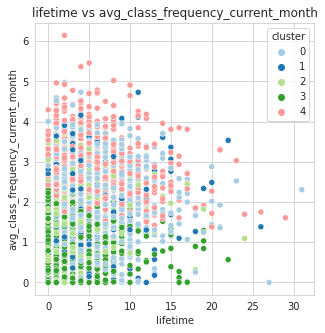

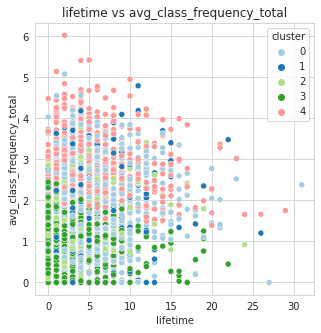

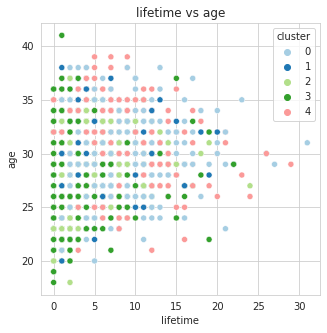

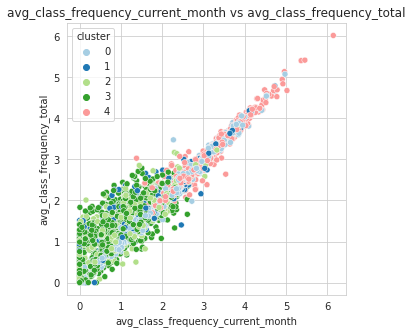

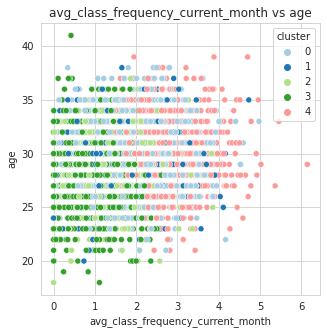

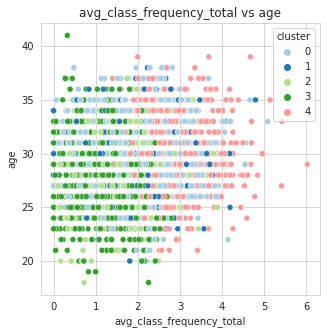

In [44]:
# change the 4 most important features
col_pairs = list(itertools.combinations(['lifetime', 'avg_class_frequency_current_month', 'avg_class_frequency_total', 'age'], 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster')

### Conclusions

We have created 5 clusters.

Clusters 0 and 4 have 1000 and 800 people and practically do not leave the fitness center, they often go to the gym, have been with the club for a long time, and also often go to group classes. They also spend the most money on additional goods.

Cluster 1 has 385 people, 27% of them have left, they do not leave their phone number, they have also been with the club for a long time and often go to the gym.

Clusters 2 and 3 have 505 and 1200 people, of which 44% and 51% have left. It can be assumed that cluster 2 abandons the hall due to the far location of the hall from his place of work/life. And cluster 3 most likely just didn’t like the gym or the fitness training itself.

## General conclusions

A dataset of 4000 records was analyzed containing information about customers: 13 features collected on the basis of customer profiles, a log of visits, purchases and information about the current status of the subscription, as well as whether there was an outflow in the previous month.

General characteristics of clients:
The fitness club is visited by clients aged 18 to 41, the average age is 29 years. Clients by gender are distributed approximately evenly (51% / 49%). Half of the customers are employees of the fitness center's partner company, and a third of the customers were enrolled as part of the "bring a friend" promotion. 41% of clients go to group classes. 15% of clients come to practice from other areas.
Only 10% of customers did not leave a contact phone number.
On average, customers spend $147 on other fitness center services.
In general, clients visit the fitness center on average about 2 times a week.
More than half of customers (55%) prefer to buy short subscriptions for 1 month.

Churn Models:
To predict customer churn in the next month, two models were built (Logistic Regression and Random Forest). A slightly better metric was shown by the logistic regression model compared to the random forest - the proportion of correct answers was 92%, that is, the model copes well with predictions. The completeness of finding all customers who were in the outflow is at the level of 83%.

Clustering:
We have created 5 clusters.
Clusters 0 and 4 have 1000 and 800 people and practically do not leave the fitness center, they often go to the gym, have been with the club for a long time, and also often go to group classes. They also spend the most money on additional goods.
Cluster 1 has 385 people, 27% of them have left, they do not leave their phone number, they have also been with the club for a long time and often go to the gym.
Clusters 2 and 3 have 505 and 1200 people, of which 44% and 51% have left. It can be assumed that cluster 2 abandons the hall due to the far location of the hall from his place of work/life. And cluster 3 most likely just didn’t like the gym or the fitness training itself.

Recommendations:

1. Build relationships with clients depending on their characteristics and needs (for certain groups of clients, you need to launch different promotions).
2. Give more promotions "Bring a friend" (because customers who come as part of the promotion are less likely to churn, most likely due to mutual motivation and a greater desire to achieve success).
3. Collect feedback for some bonuses (extra workouts, free partner referral, free protein shakes, etc.) and respond to critical moments.